# Выбор локации для скважины

**Описание проекта**

Компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. В данных для анализа есть три региона с наборм данных. На основе расчетов нужно выбрать лучший регион 

План работы 
* [Шаг 0. Импорт библиотек и методы](#step0)
* [Шаг 1. Загрузка данных](#step1)
* [Шаг 2. Изучение и подготовка данных](#step2)
* [Шаг 3. Создание и обучение модели](#step3)
* [Шаг 4. Расчет прибыли, выбор лучшего региона](#step4)

# Шаг 0. Импорт библиотек и методы

<a id="step0"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import shapiro


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


#Созданинн констант 
RANDOM_STATE = 42
POINT = 500
POINT_BEST = 200
BUDGET = 10_000_000_000
INCOME_PER_BARREL = 450
INCOME_PER_PRODUCT = INCOME_PER_BARREL * 1000

warnings.filterwarnings('ignore')


/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def duplicates(columns, df):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')

In [3]:
def create_histogram(data, column):
    """
    Input:
    - data: Датафрейм, содержащий данные.
    - column: Наименование столбца, для которого нужно построить гистограмму.
    - title: Заголовок гистограммы.
    - bins: Количество бинов для гистограммы (по умолчанию 50)

    Output:
    - None

    Description:
    Функция создает гистограмму для указанного столбца в датафрейме при помощи библиотеки seaborn. 
    Результат выводится на экран.
    """
    plt.figure(figsize=(12, 6))
    sns.set()
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins)
    plt.title(f'{column} - Частота распределения', fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [4]:
def shapiro_test(data, column):
    """
    Функция выполняет тест Шапиро-Уилка на нормальность данных в указанном столбце.

    Параметры:
        - data: pandas DataFrame, входные данные
        - column: str, название столбца, для которого выполняется тест

    Вывод:
        - печать результата теста Шапиро-Уилка, включая статистику теста и p-значение
        - вывод сообщения о том, является ли распределение данных нормальным
    """ 
    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [5]:
def create_boxplot(data, column):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, которая будет отображена на оси x.
    
    Output:
    None
    
    Description:
    Функция создает график ящика с усами на основе указанных столбцов.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Ящик с усами для {column}')
    plt.xlabel(column)
    plt.show()

In [6]:
def plot_heatmap(dataframe, columns, method):
    """
    Input:
    - dataframe (DataFrame): Исходный DataFrame с данными.
    - interval_cols (list): Список названий интервальных признаков для расчета коэффициента корреляции Спирмена.
    
    Output:
    None
    
    Description:
    Эта функция вычисляет матрицу корреляций на основе коэффициента корреляции Спирмена для указанных интервальных признаков и строит тепловую карту на основе этой матрицы с использованием библиотеки seaborn.
    """
    # Вычисление матрицы корреляций на основе коэффициента корреляции Спирмена
    spearman_matrix = dataframe[columns].corr(method=method)

    # Использование цветовой карты RdYlBu для лучшей визуализации
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Создание тепловой карты на основе матрицы корреляций Спирмена
    plt.figure(figsize=(10, 8))
    sns.heatmap(spearman_matrix, annot=True, cmap=cmap, center=0, square=True, linewidths=.5)
    plt.title('Корреляция. Тепловая карта')
    plt.show()


In [7]:
def split(df, target_column):
    features = df.drop(columns=target_column, axis=1)
    target = df[target_column]
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=RANDOM_STATE)
    return features_train, features_valid, target_train, target_valid



# Шаг 1. Загрузка данных

<a id="step1"></a>

In [8]:
try:
    df_geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
except FileNotFoundError:
    print('Что-то пошло не так')

In [9]:
df_geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [10]:
df_geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
df_geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
df_geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
df_geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [14]:
df_geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


По первому рассмотрению данных у нас есть информация о георазведки в трех регионах. Во всех файлах содержится 100000 записей и нет пропусков. В датафреймах есть следующая информация 
* id - уникальный идентификатор скважины
* f0, f1, f2 - три признака точек 
* product - объём запасов в скважине (тыс. баррелей)

# Шаг 2. Подготовка данных

<a id="step2"></a>

Удалим id из всех трех датафреймов. Это ненужный признак

In [15]:
dataframes = [df_geo_data_0, df_geo_data_1, df_geo_data_2]
for df in dataframes:
   df = df.drop('id', axis=1, inplace=True)

Проверим наличие дубликатов

In [16]:
for data in dataframes:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace=True)
        print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме df_geo_data_0: 0
Количество дубликатов в датафрейме df_geo_data_1: 0
Количество дубликатов в датафрейме df_geo_data_2: 0


Построим гистограммы и боксплоты

In [17]:
columns = [column for column in df_geo_data_0]


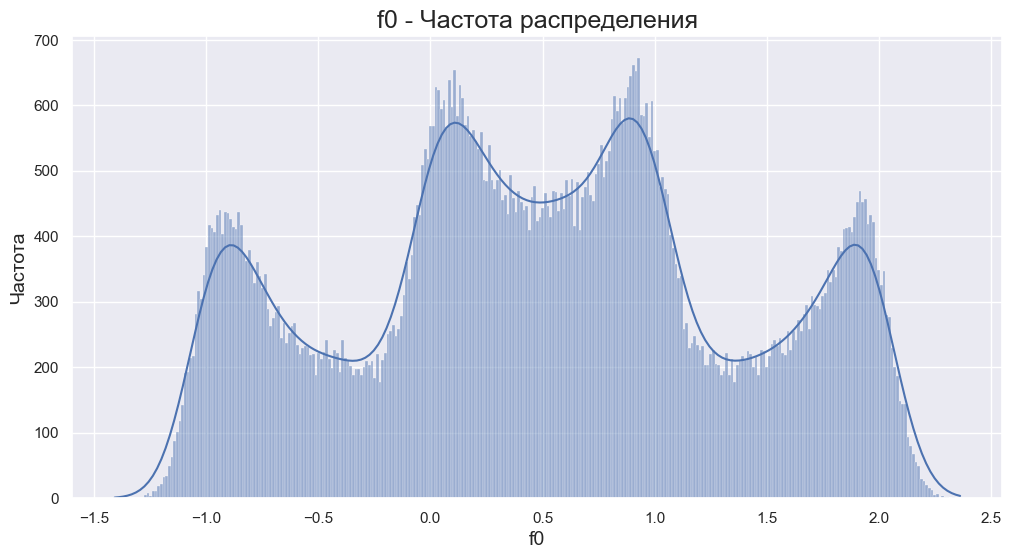

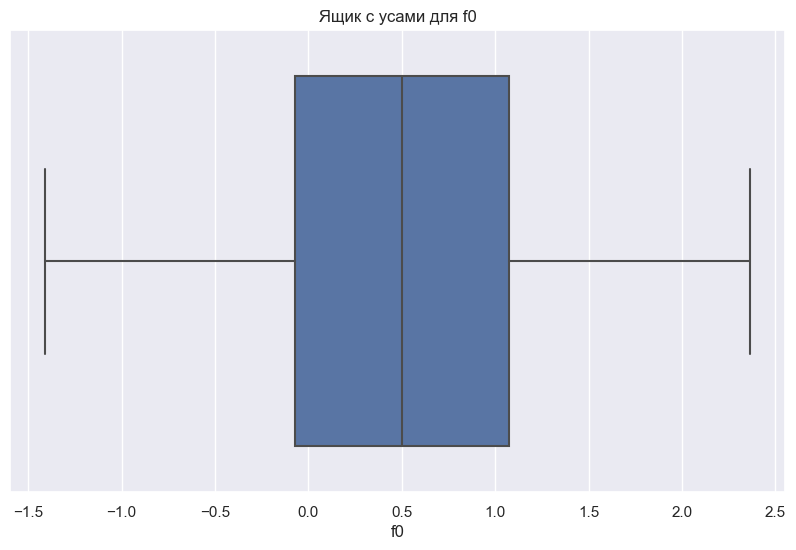

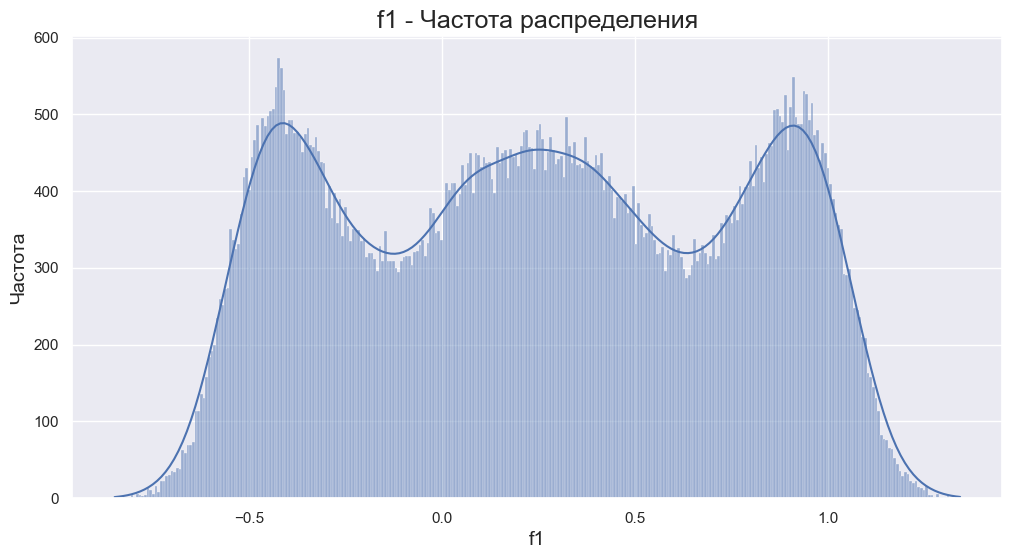

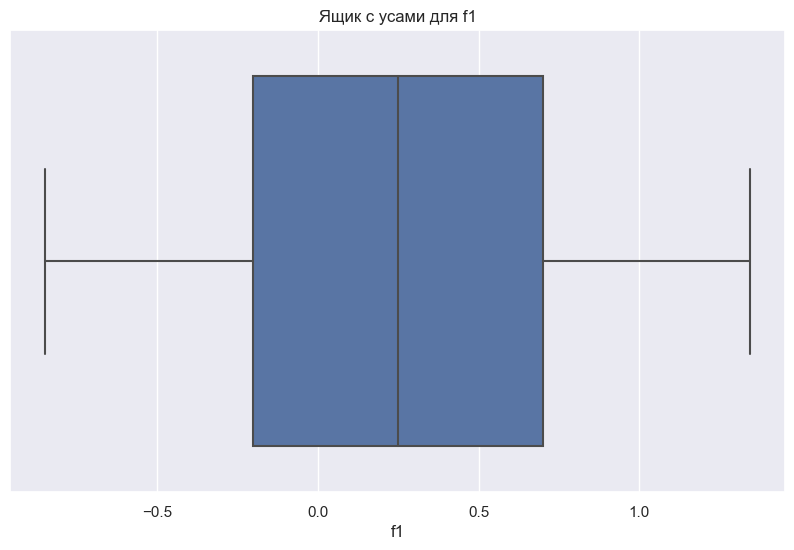

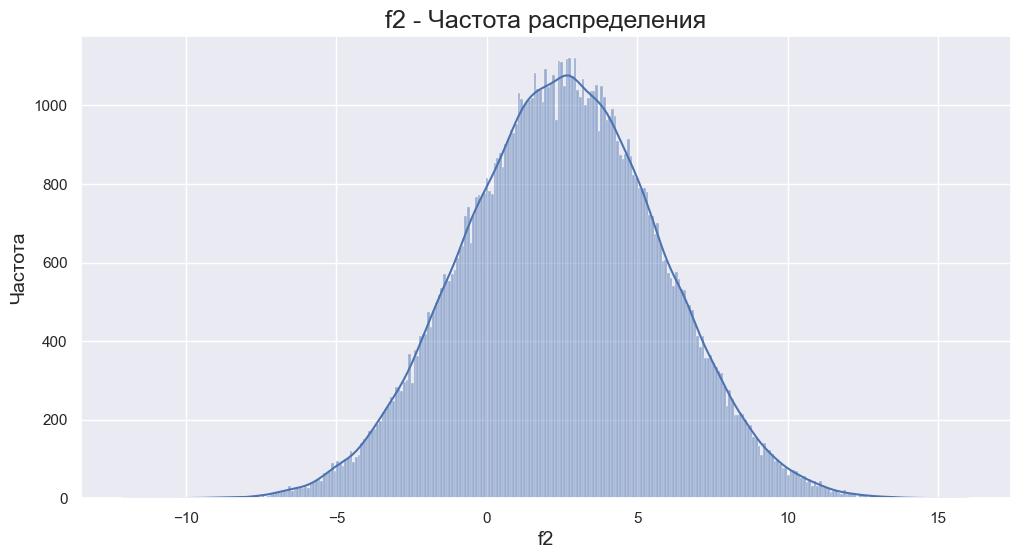

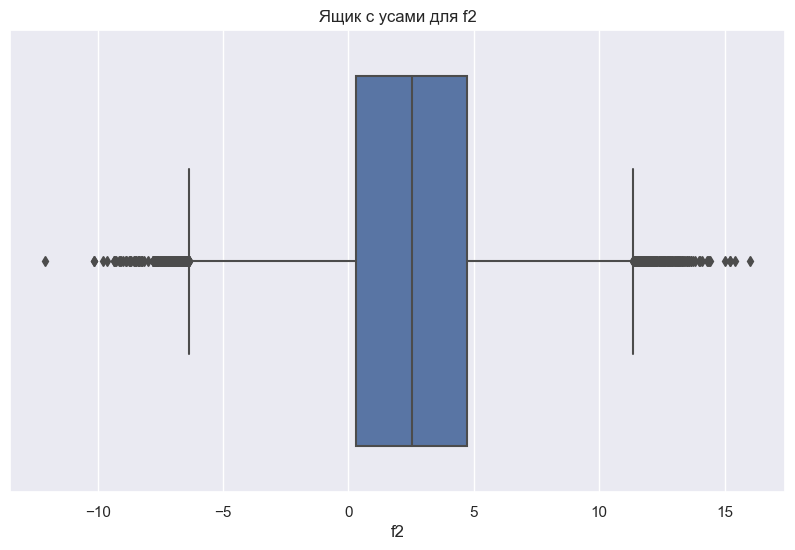

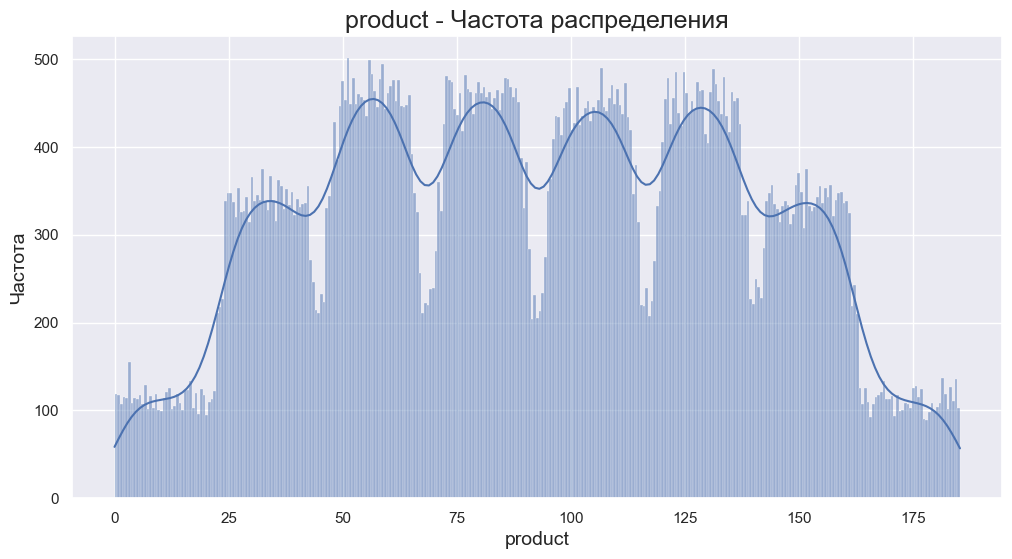

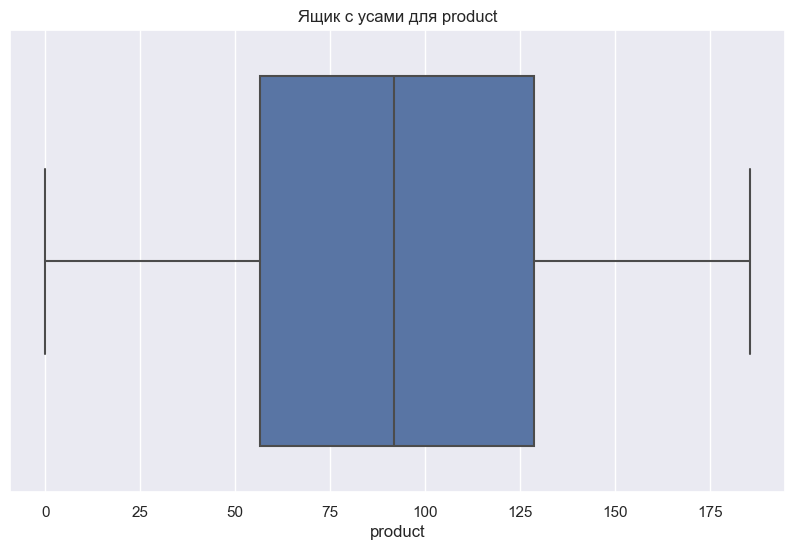

In [18]:
for column in columns:
    create_histogram(df_geo_data_0, column)
    create_boxplot(df_geo_data_0, column)

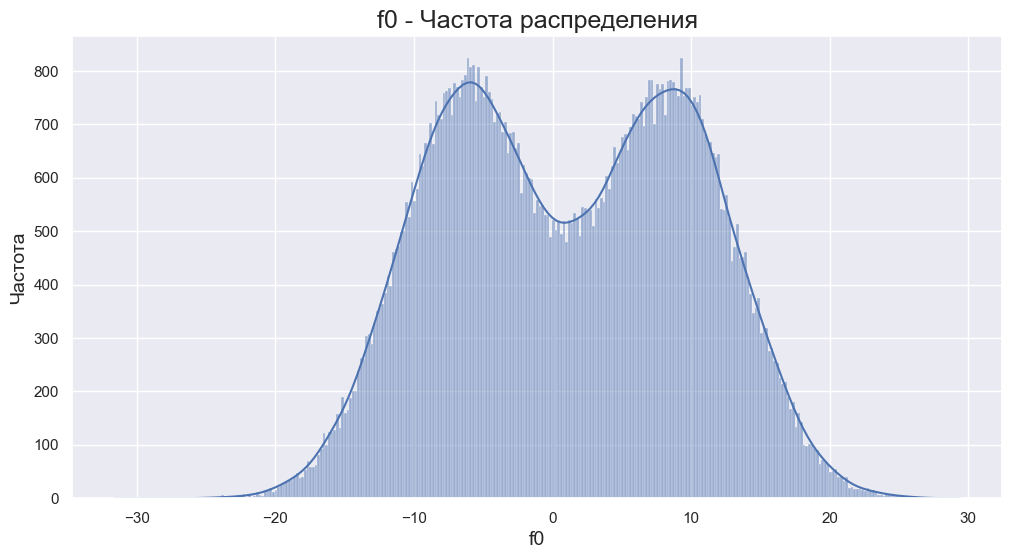

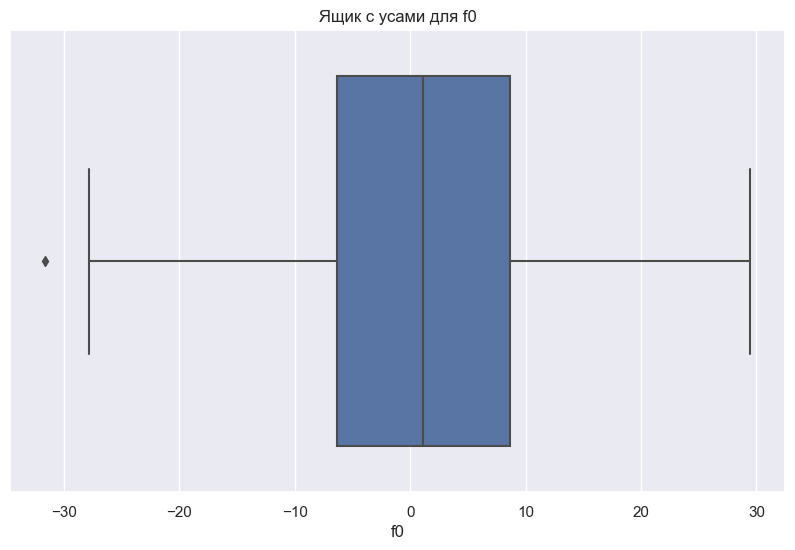

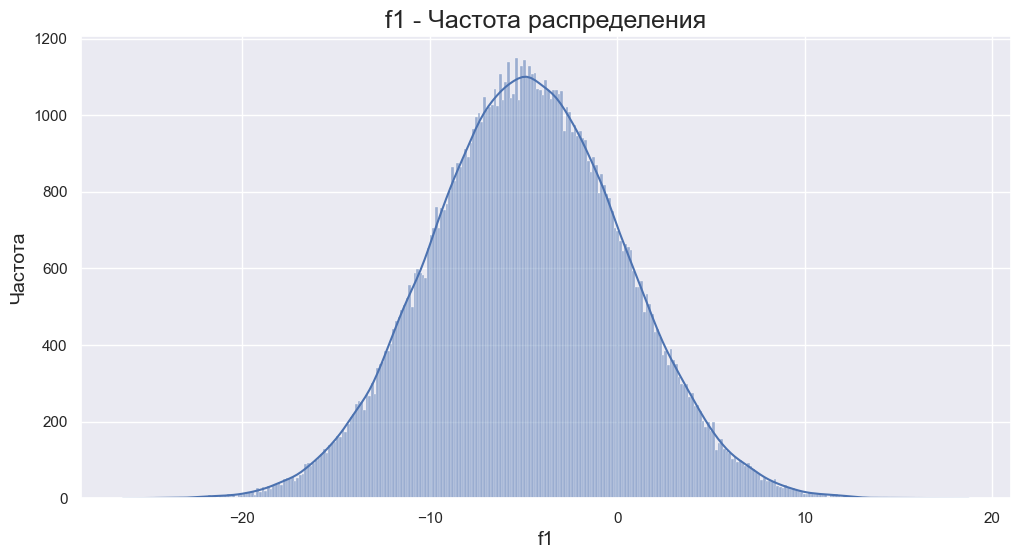

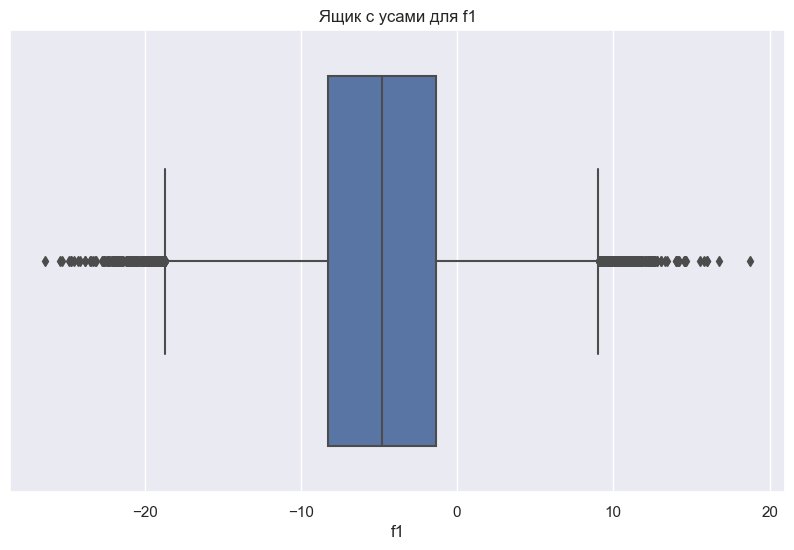

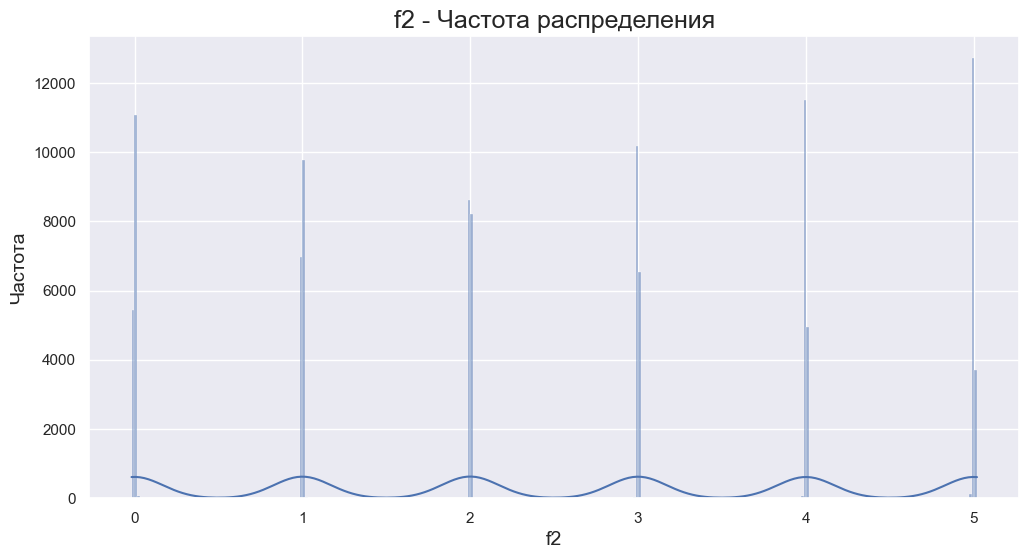

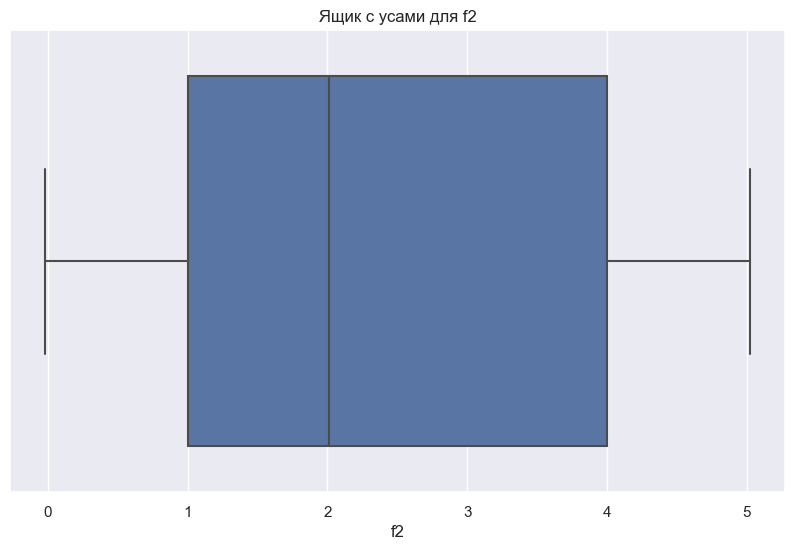

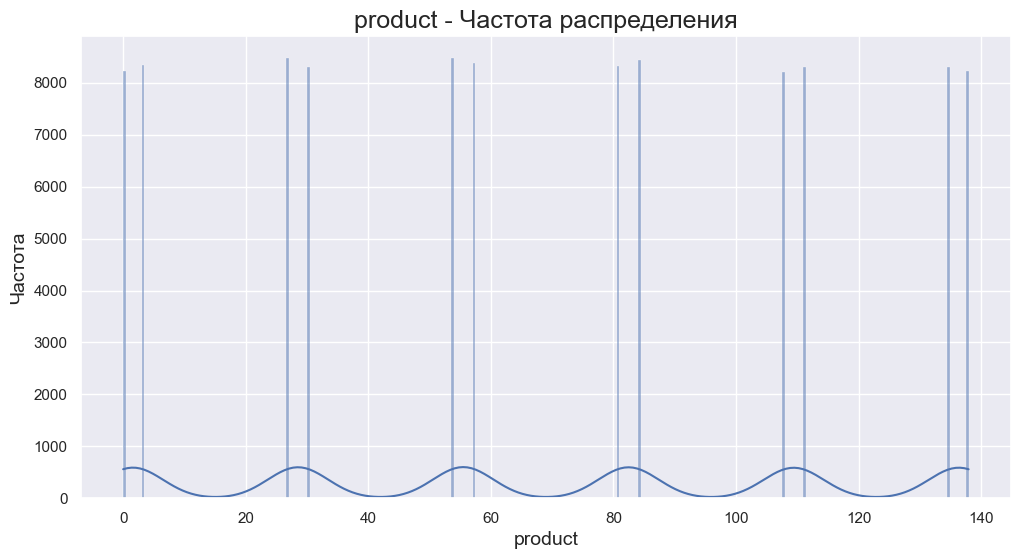

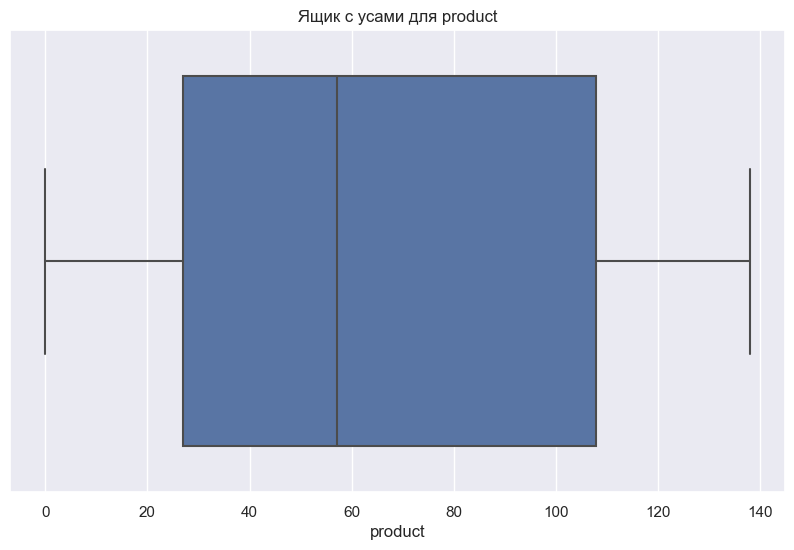

In [19]:
for column in columns:
    create_histogram(df_geo_data_1, column)
    create_boxplot(df_geo_data_1, column)

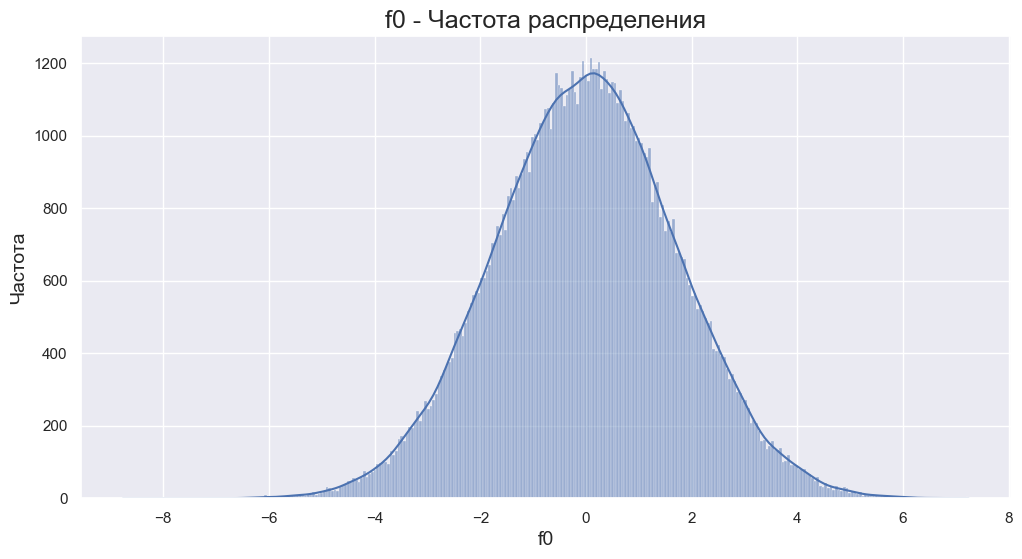

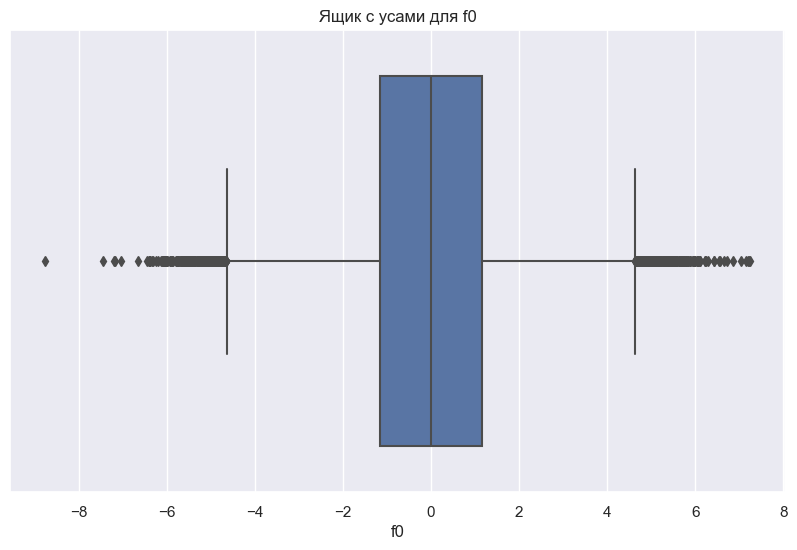

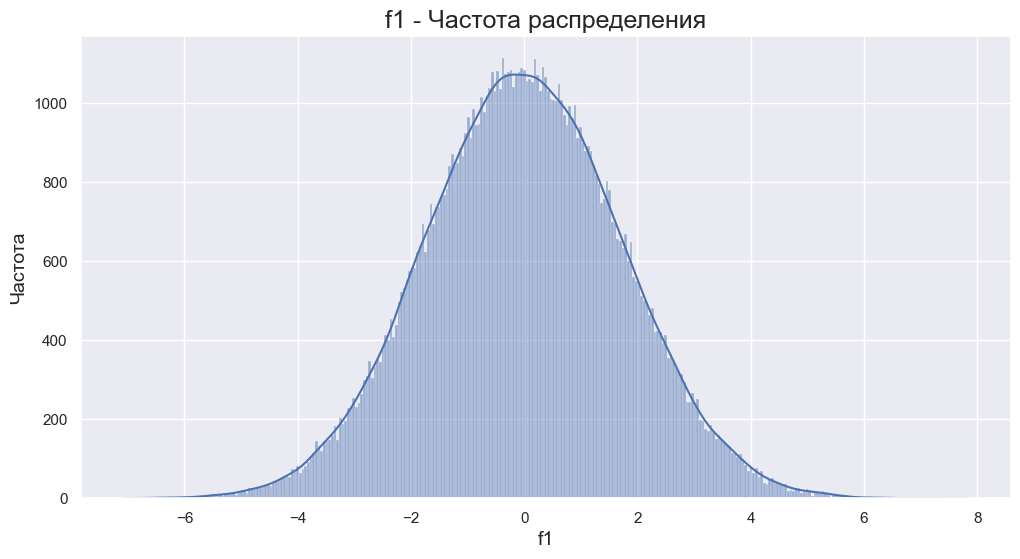

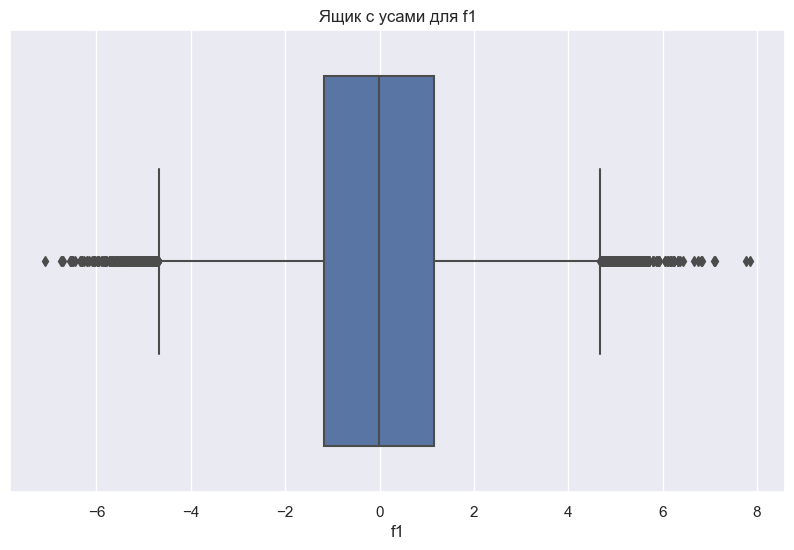

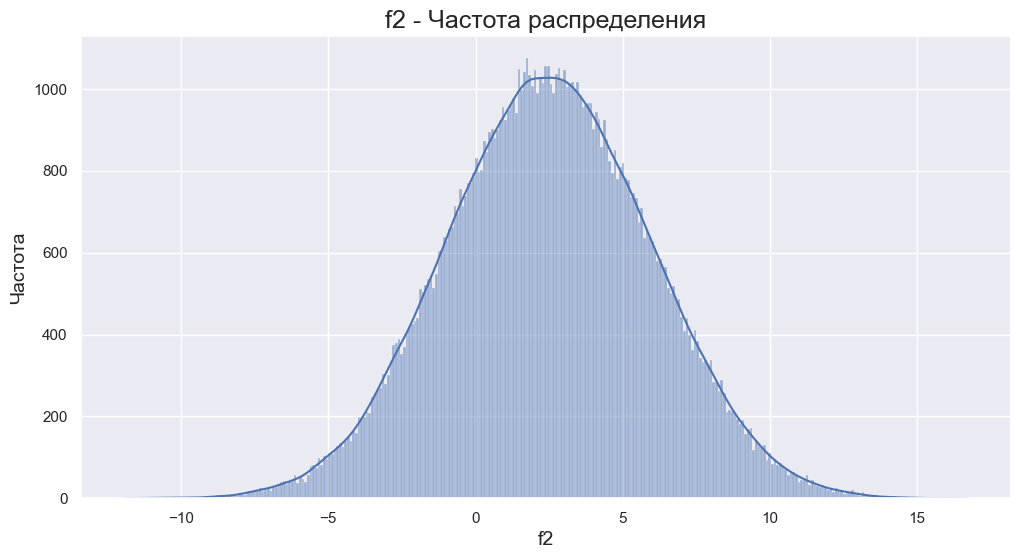

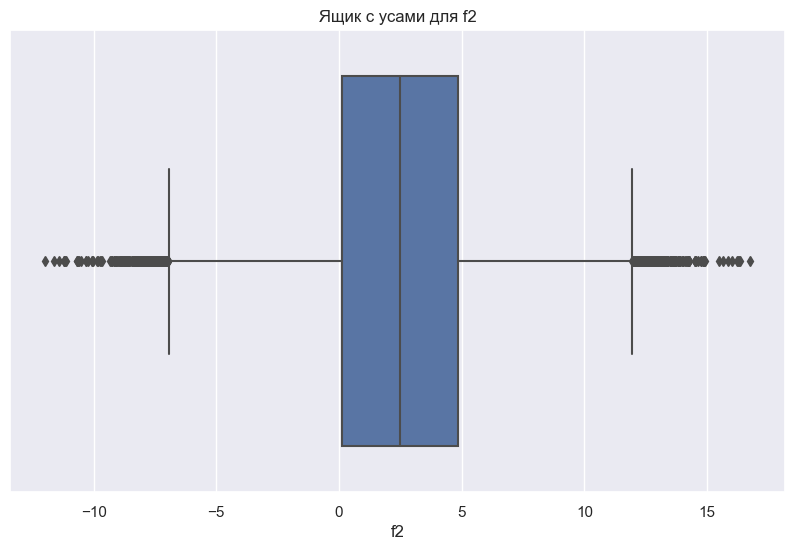

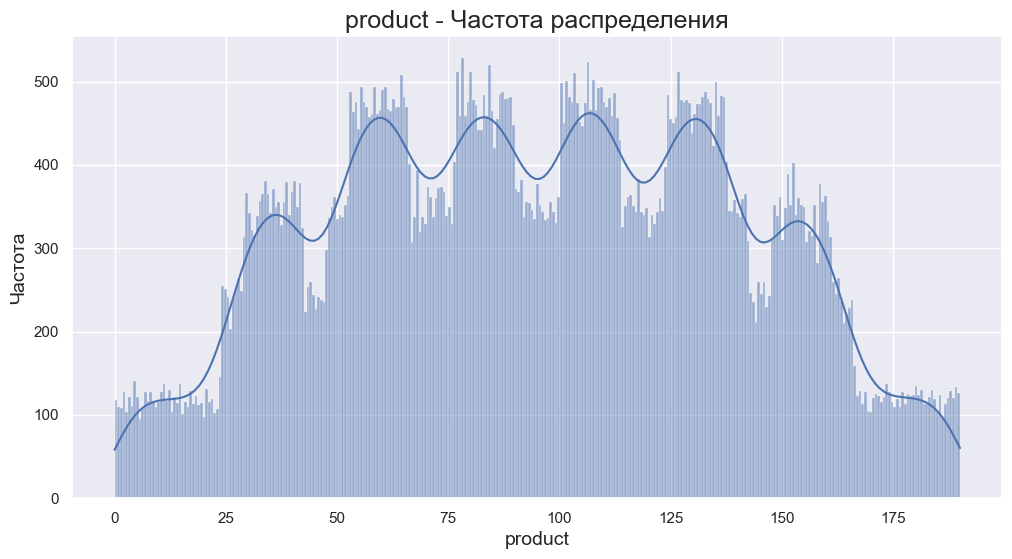

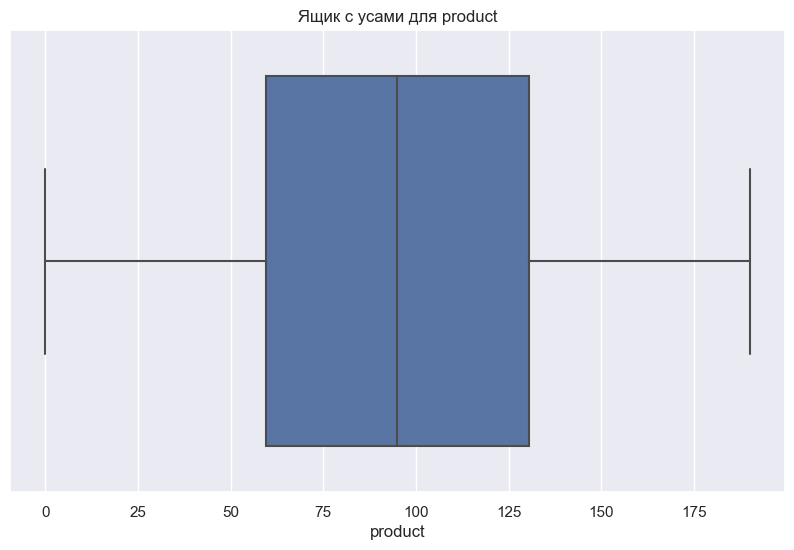

In [20]:
for column in columns:
    create_histogram(df_geo_data_2, column)
    create_boxplot(df_geo_data_2, column)

В даннных есть небольшие выбросы, но их лучше никак не убирать, поскольку в будущем может привести к недообучению модели. 
Теперь проверим все ли данные имеют нормальное распределение 

In [21]:
for column in columns:
    shapiro_test(df_geo_data_0, column)
    print()

Результат теста Шапиро-Уилка для столбца f0:
Статистика теста: 0.9720327258110046
p-значение: 0.0
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца f1:
Статистика теста: 0.9573717713356018
p-значение: 0.0
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца f2:
Статистика теста: 0.9998477101325989
p-значение: 8.208100553019904e-06
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца product:
Статистика теста: 0.9789736866950989
p-значение: 0.0
Распределение данных не является нормальным.



In [22]:
for column in columns:
    shapiro_test(df_geo_data_1, column)
    print()

Результат теста Шапиро-Уилка для столбца f0:
Статистика теста: 0.978449285030365
p-значение: 0.0
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца f1:
Статистика теста: 0.9999602437019348
p-значение: 0.2935238778591156
Распределение данных является нормальным.

Результат теста Шапиро-Уилка для столбца f2:
Статистика теста: 0.9083220958709717
p-значение: 0.0
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца product:
Статистика теста: 0.91861492395401
p-значение: 0.0
Распределение данных не является нормальным.



In [23]:
for column in columns:
    shapiro_test(df_geo_data_2, column)
    print()

Результат теста Шапиро-Уилка для столбца f0:
Статистика теста: 0.9999710321426392
p-значение: 0.6339747309684753
Распределение данных является нормальным.

Результат теста Шапиро-Уилка для столбца f1:
Статистика теста: 0.9999850392341614
p-значение: 0.9857209324836731
Распределение данных является нормальным.

Результат теста Шапиро-Уилка для столбца f2:
Статистика теста: 0.9999154210090637
p-значение: 0.003915195353329182
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца product:
Статистика теста: 0.9827926158905029
p-значение: 0.0
Распределение данных не является нормальным.



У большинства предоставленнх данных распределение не является нормальным, поэтому для проведения анализа корреляции используем метод Спирмена 

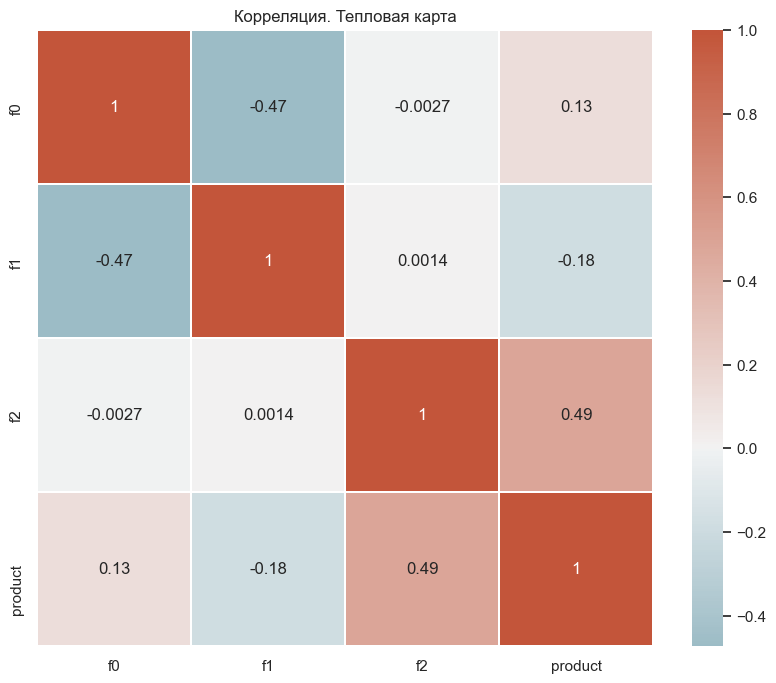

In [24]:
plot_heatmap(df_geo_data_0, columns, 'spearman')


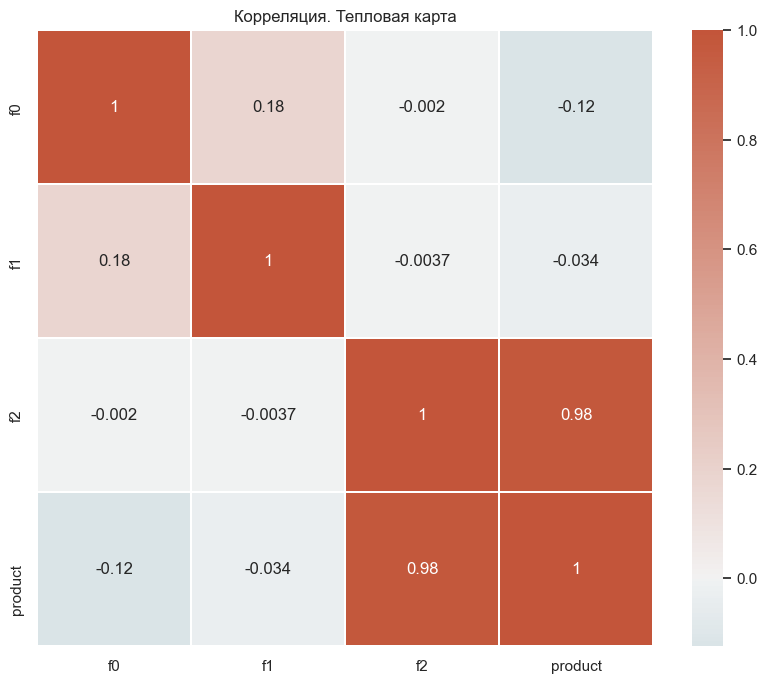

In [25]:
plot_heatmap(df_geo_data_1, columns, 'spearman')

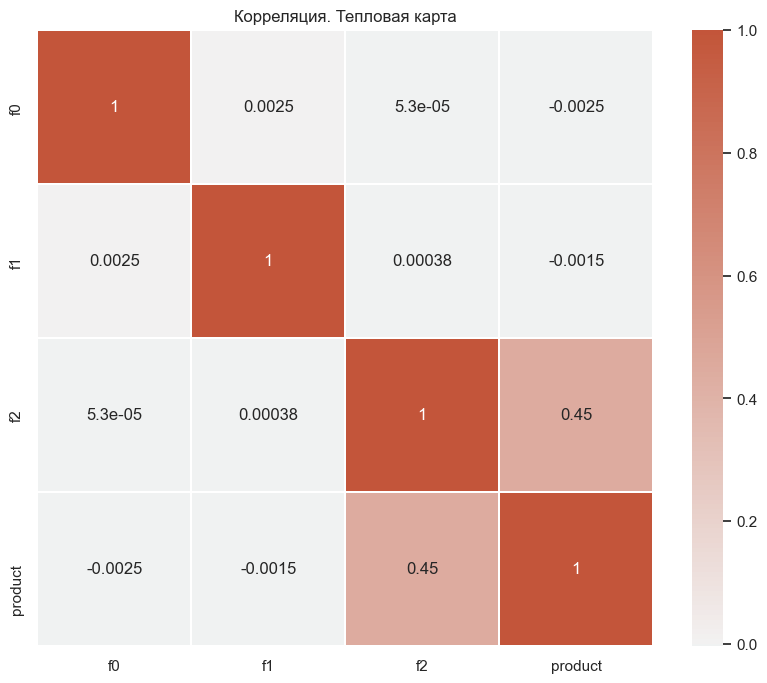

In [26]:
plot_heatmap(df_geo_data_2, columns, 'spearman')

Во второй локации наблюдается сильная положительная корреляция между f2 и целевым признаком. В остальных случаях ее либо нет совсем, либо она очень слабая 

# Шаг 3. Обучение модели

<a id="step3"></a>

Разделим выборки на тренировочную и валидационную в в соотношении 75:25

In [27]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(df_geo_data_0, 'product')

features_train_1, features_valid_1, target_train_1, target_valid_1 = split(df_geo_data_1, 'product')

features_train_2, features_valid_2, target_train_2, target_valid_2 = split(df_geo_data_2, 'product')



Создадим пайплайн в котором будем использовать модель - линейную регрессию и StandardScaler для масштабирования данных

In [28]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  
    ('model', LinearRegression()) 
])


In [29]:
def calculate_rmse_and_predictions(model, X_train, y_train, X_valid, y_valid):
    ''' 
    Input:
    - model: Обученная модель для прогнозирования.
    - X_train: Обучающие данные для признаков.
    - y_train: Обучающие данные для целевой переменной.
    - X_valid: Валидационные данные для признаков.
    - y_valid: Валидационные данные для целевой переменной.
    
    Output:
    - rmse: Значение среднеквадратичной ошибки (RMSE).
    - mean_prediction: Среднее значение предсказаний.
    - predictions: Массив предсказаний модели на валидационных данных.
    
    Description:
    Эта функция обучает модель на обучающих данных, делает предсказания 
    на валидационных данных и вычисляет среднеквадратичную ошибку (RMSE). 
    Она также возвращает среднее предсказание и массив предсказаний модели.
    '''
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    
    mse = mean_squared_error(y_valid, predictions)
    rmse = np.sqrt(mse)
    
    mean_prediction = predictions.mean()
    
    return rmse, mean_prediction, predictions

Обучим модель, сделаем предсказание. После создадим датафреймы для предсказаний, а также для вывода rmse и среднего предсказанного значения 

In [30]:
rmse_0, mean_pred_0, predictions_0 = \
calculate_rmse_and_predictions(pipeline, features_train_0, target_train_0, features_valid_0, target_valid_0)

rmse_1, mean_pred_1, predictions_1 = \
calculate_rmse_and_predictions(pipeline, features_train_1, target_train_1, features_valid_1, target_valid_1)

rmse_2, mean_pred_2, predictions_2 = \
calculate_rmse_and_predictions(pipeline, features_train_2, target_train_2, features_valid_2, target_valid_2)

In [31]:
predictions = {
    'predictions_0': predictions_0,
    'predictions_1': predictions_1,
    'predictions_2': predictions_2
}

df_predictions = pd.DataFrame(predictions)
df_predictions.head()

,predictions_0,predictions_1,predictions_2
0,101.901017,0.844738,98.301916
1,78.217774,52.921612,101.592461
2,115.266901,135.110385,52.449099
3,105.618618,109.494863,109.922127
4,97.980185,-0.047292,72.411847


In [32]:
region_data = [
    {'Регион': 0, 'RMSE': rmse_0, 'mean_pred': mean_pred_0, 
     'mean_real': df_geo_data_0['product'].mean()},
    {'Регион': 1, 'RMSE': rmse_1, 'mean_pred': mean_pred_1, 
     'mean_real': df_geo_data_1['product'].mean()},
    {'Регион': 2, 'RMSE': rmse_2, 'mean_pred': mean_pred_2,
     'mean_real': df_geo_data_2['product'].mean()}
]

df_result = pd.DataFrame(region_data)


df_result

,Регион,RMSE,mean_pred,mean_real
0,0,37.756600,92.398800,92.500
1,1,0.890280,68.712878,68.825
2,2,40.145872,94.771024,95.000


Значение метрики RMSE (среднеквадратичная ошибка) используется для измерения точности модели прогнозирования. Чем ниже значение RMSE, тем лучше качество модели. Самое низкое RMSE у Региона 1 - 0.89

# Шаг 4. Прибыль

Расчитаем достаточный объем для безубыточной разработки скважины по каждому региону

In [33]:
margin = BUDGET / INCOME_PER_PRODUCT / 200
margin

111.11111111111111

Для безубыточной разработки скважины необходимы запасы в  111.11 тыс. баррелей нефти. Средние запасы нефти в регионах меньше чем безубыток.  

Напишем функцию для расчета прибыли. Для расчетов выбираем 200 лучших точек. 

In [34]:
def income(predictions, target):
    """
    Input:
    - predictions: Массив предсказаний модели.
    - target: Целевой признак для расчета дохода.

    Output:
    - income: Рассчитанный доход от выбора объектов в соответствии с предсказаниями модели.

    Description:
    Эта функция принимает массив предсказаний модели и целевую переменную для расчета дохода. 
    Она сначала выбирает top объектов с наилучшими предсказаниями, затем определяет их 
    соответствующие значения из целевой переменной. Напоследок, функция расчитывает прибыль, 
    вычисляя разницу между общей выручкой от выбранных объектов 
    (с учетом стоимости продукции) и бюджета на проект.
    """
    best_predict = pd.Series(predictions).sort_values(ascending=False).head(POINT_BEST)
    selected = target.iloc[best_predict.index]
    income = (INCOME_PER_PRODUCT * selected.sum()) - BUDGET
    return income

Расчитаем прибыль для трех регионов и сохраним данные в датафрейме 

In [35]:

income_0 = income(predictions_0, target_valid_0)
income_1 = income(predictions_1, target_valid_1)
income_2 = income(predictions_2, target_valid_2)


income_data = {
    'Регион 0': pd.Series(income_0),
    'Регион 1': pd.Series(income_1),
    'Регион 2': pd.Series(income_2)
}

income_df = pd.DataFrame(income_data)



income_df

,Регион 0,Регион 1,Регион 2
0,3.359141e+09,2.415087e+09,2.598572e+09


Напишем функцию для расчетов средней прибыли, рисков и значений минимального и максимального значений 95% интервала. При использовании бутстрепа в семпл передадим 500 случайных точек 

In [36]:
def bootstrap(predict, target):
    """
   Input:
   - predict: Массив предсказаний модели.
   - target: Целевая переменная для расчета дохода.

   Output:
   - mean: Среднее значение прибыли.
   - risk: Процент случаев, когда прибыль оказывается отрицательным.
   - confidence_interval[0]: Нижняя граница 95% доверительного интервала для прибыли.
   - confidence_interval[1]: Верхняя граница 95% доверительного интервала для прибыли.

   Description:
   Эта функция выполняет процедуру бутстрэпа для оценки доходности.
   Она генерирует 1000 случайных подвыборок из предсказанных значений (predict) и 
   использует функцию income для расчета доходности каждой подвыборки. 
   После этого функция определяет среднее значение дохода, риск получения отрицательного дохода,
   и 95% доверительный интервал для дохода. 
   """
    target = target.reset_index(drop=True)
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
      probs_subsample = pd.Series(predict).sample(n=POINT, replace=True, random_state=state)
      values.append(income(probs_subsample, target))

    values = pd.Series(values)

    mean = values.mean()
    risk = (values < 0).mean() * 100
    confidence_interval = stats.t.interval(0.95, len(values)-1, loc=mean, scale=values.sem())

    return mean, risk, confidence_interval[0], confidence_interval[1]

Применим эту функцию для трех регионов и сохраним данные в новом датафрейме 

In [37]:
mean_region_0, risk_region_0, lower_reqion_0, upper_region_0 = \
bootstrap(predictions_0, target_valid_0)

mean_region_1, risk_region_1, lower_reqion_1, upper_region_1 = \
bootstrap(predictions_1, target_valid_1)

mean_region_2, risk_region_2, lower_reqion_2, upper_region_2 = \
bootstrap(predictions_2, target_valid_2)

In [38]:
final_data = {
    'Регион': ['Регион 0', 'Регион 1', 'Регион 2'],
    'Прибыль': [mean_region_0, mean_region_1, mean_region_2],
    'Риски': [risk_region_0, risk_region_1, risk_region_2],
    'Квантиль 0.025': [lower_reqion_0, lower_reqion_1, lower_reqion_2],
    'Квантиль 0.975': [upper_region_0, upper_region_1, upper_region_2]

}

df_final = pd.DataFrame(final_data)
df_final['Средняя добыча нефти'] = df_result['mean_pred']
df_final = df_final.round(0)
df_final

,Регион,Прибыль,Риски,Квантиль 0.025,Квантиль 0.975,Средняя добыча нефти
0,Регион 0,406278783.0,7.0,389978382.0,422579185.0,92.0
1,Регион 1,432624132.0,2.0,420008022.0,445240242.0,69.0
2,Регион 2,377362192.0,7.0,360616370.0,394108015.0,95.0


# Вывод

В целях проекта нужно выбрать лучший регион для бурения новой скважины. На анализ нам были данные входные данные, такие как - три датасета с тремя разными регионами.
Для безубыточного бурения новой скважины необходимо, чтобы объем нефти был больше 111.11 тысяч боррелей. 
После подготовки данных и обучения модели мы получили метрику RMSE 
* Регион 0 - 37.756600
* Регион 1 - 0.890280
* Регион 2 - 0.890280

Лучший результат метрики у Региона 1, но средний предсказанный объем нефти - 68.825. При этом у этого региона самые маленькие риски, всего 2% против 7 в остальных двух регионах, и самая большая прибыль - 432624132. 

Поэтому на основе полученных данных рекомендуется выбрать Регион 1. 
